In [1]:
import sys
!{sys.executable} -m pip install numpy scipy tsfresh matplotlib gensim glob

/bin/bash: {sys.executable}: command not found


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

# Prediction of disease type from topological features of time series
(Submission: G. Petri, A. Leitao)

## Introduction 

Diseases and their spreading patterns have been studied object of attention for a long time, both from the biological and epidemiological perspective. 

Being able to characterize both aspects is crucial for a timely response to outbreaks at the individual and population level.  This is of even greater importance for emerging epidemics, of which COVID-19 is just the most tragic and recent example. 

Unfortunately, it can take a long time before researchers are able to pinpoint the spreading mechanisms for a specific novel pathogen. However, what if we could use the epidemic curve of a novel pathogen to predict what is the known disease that it resembles the most? 
In this case, we would be able to leverage interventions that have been developed for the latter disease to try and mitigate the former. 

In order to this, we first need to learn whether we can learn what known diseases look like in terms of their epidemic curves. The aim of this notebook is to show that --employing topological features obtained from time series-- it is possible to accurately predict the disease from a set of epidemic curves. 

In particular, we build on recent work on the [structure of predictability of epidemic outbreaks](https://www.nature.com/articles/s41467-019-08616-0) and construct embeddings that use both the temporal and ordinal properties of the data. 

## Dataset 
The data (included with the notebook) is a selection (N=454) of the US epidemic timeseries used in [Scarpino&Petri](https://www.nature.com/articles/s41467-019-08616-0), spanning in some cases more than 20 years. 
The time resolution is weekly. 
We note that the timeseries are of different lengths, start and end at different instants in time, and at times contain intervals of missing values. 
We deliberately leave also the noisy and faulty timeseries within the dataset in order to highlight the (honestly surprising) robustness of the results. 

In [3]:
import glob
fs = glob.glob('../data/limits/*.csv');

X_ts, y_labels = [], []
from tqdm.notebook import tqdm
for f in tqdm(fs[:460]):
    data = pd.read_csv(f);
    X_ts.append(data.fillna(0).x);
    y_labels.append(f.split('/')[-1].split('-')[0])

We show below a random selection of epidemic curves from the dataset:

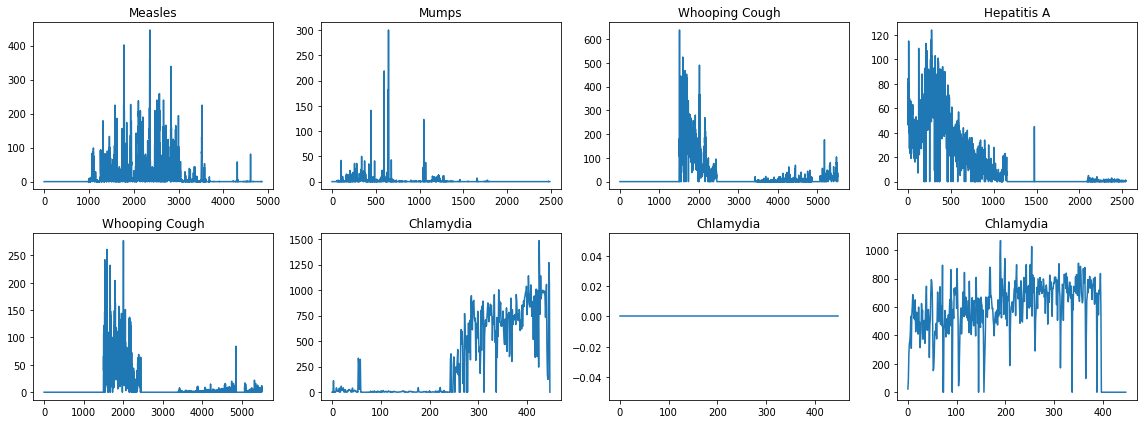

In [4]:
iss = np.random.randint(0,455, 8)
fig = plt.figure(figsize=(16,6))
count=1
for i in iss:
    plt.subplot(2,4, count)
    X_ts[i].plot()
    plt.title(y_labels[i])
    count+=1
plt.tight_layout()    

The selection of timeseries also provides a rather balanced class assignment. 

In [5]:
from collections import Counter
print(Counter(y_labels))

Counter({'Influenza': 61, 'Chlamydia': 60, 'Hepatitis A': 60, 'Gonorrhea': 59, 'Mumps': 59, 'Whooping Cough': 58, 'Polio': 52, 'Measles': 51})


## Pipeline

The analysis is as follows:
1. we import the timeseries and transform them into their symbolic version (a la permutation entropy)
2. from the symbolized timeseries, we create embeddings using Word2Vec;
3. we then compute VR persistent homology on the resulting embeddings and extract simple features from the persistence diagrams (amplitude, persistence entropy, Betti numbers);
4. We then feed these features to a classifier to learn disease types.
5. In parallel, we also repeat the same analysis on the Takens embeddings extracted from the epidemic timeseries.
6. Finally, we join the two sets of features, coming from symbolic and Takens embeddings, and show that their combination is able to outperform a classifier based on standard timeseries features. 
    



# Epidemic timeseries and their symbolization

In [ ]:
from numpy.random import randn, randint

def noisy_symbolic_sequence(time_series, m, delay,noise_amp=0.3):
    import itertools
    import numpy as np
    n = len(time_series)
    permutations = np.array(list(itertools.permutations(range(m))))
    c = [0] * len(permutations)
    new_sequence = []
    for i in range(n - delay * (m - 1)):
        sorted_index_array = ''.join(map(str,np.argsort(time_series[i:i + delay * m:delay] + noise_amp*randn(len(time_series[i:i + delay * m:delay])),
                                                 kind='quicksort')))
        new_sequence.append(sorted_index_array);
    return new_sequence;

text = []
for x in X_ts:
    text.append(noisy_symbolic_sequence(x, 5, 1, noise_amp=0.01))

We associate to each timeseries a symbolic timeseries built from the ordinal patterns in short strings of values. 
This is the same procedure that is performed before computing permutation entropy, details can be found in the paper linked in the introduction. 

The function above to extract the symbolic timeseries includes a source of noise, which is used to remove draws in the construction of the ordinal patterns. It also simulates the noise that is likely present in disease incidence measurements. Similarly to Scarpino&Petri, we set the delay time to 1 to have temporally continuous windows, and  the embedding dimension to 5 (which is the typical value observed in previous studies for weekly timeseries).  

## Construction of Word2vec embeddings for symbolized timeseries 

In [ ]:
# node2vec parameters
param_p = 1.0
param_q = 1.0
param_dimensions = 10
param_window = 4
param_num_workers = 8
param_iter = 1

# compute "word" embeddings
Xs = []
for tt in tqdm(text):
    model = Word2Vec(sentences=[tt],
                 size=param_dimensions,
                 window=param_window,
                 min_count=0,
                 sg=1,
                 negative=5,
                 iter=param_iter,
                 workers=param_num_workers);
    Xs.append(model.wv.vectors);

### Computation of VR persistence on symbolic embeddings
For illustration purposes we separate the computation of homology and diagrams for the two studied dimensions [0,1]


In [ ]:
symbolic_diags = {}
amps_dict, ents_dict, betti_dict = {}, {}, {}

In [ ]:
from gtda.diagrams import Amplitude, PersistenceEntropy, NumberOfPoints
from gtda.homology import VietorisRipsPersistence

dim = 0
VR = VietorisRipsPersistence(metric='correlation', homology_dimensions=[dim])
VR.fit(Xs)
symbolic_diags[dim] = VR.transform(Xs)
amps_dict[dim] = Amplitude(metric='heat', metric_params={'sigma': 0.05}).fit_transform(symbolic_diags[dim])
ents_dict[dim] = PersistenceEntropy(normalize=True).fit_transform(symbolic_diags[dim])
betti_dict[dim] = NumberOfPoints().fit_transform(symbolic_diags[dim])

dim = 1
VR = VietorisRipsPersistence(metric='correlation', homology_dimensions=[dim])
VR.fit(Xs)
symbolic_diags[dim] = VR.transform(Xs)
amps_dict[dim] = Amplitude(metric='heat', metric_params={'sigma': 0.05}).fit_transform(symbolic_diags[dim])
ents_dict[dim] = PersistenceEntropy(normalize=True).fit_transform(symbolic_diags[dim])
betti_dict[dim] = NumberOfPoints().fit_transform(symbolic_diags[dim])


### Joining together topological features of different dimensions from symbolic embeddings

In [ ]:
X_features = np.array(list(zip([x[0] for x in amps_dict[0]], [x[0] for x in ents_dict[0]], 
                               [x[0] for x in amps_dict[1]], [x[0] for x in ents_dict[1]],
                               [x[0] for x in betti_dict[1]])))


### prediction of disease type using only features from symbolic embeddings

In [ ]:
from time import time 
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
summary_dict = {}
summary_dict['symbolic only'] = []

X, y = X_features, y_labels

gnb = GaussianNB()
scores = cross_val_score(gnb, X, y, cv=5)
print('GNB', scores.mean(), scores.std())
summary_dict['symbolic only'].append(scores.mean())


clf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=int(time()))
scores = cross_val_score(clf, X, y, cv=5)
print('Random Forest Classifier', scores.mean(), scores.std())
summary_dict['symbolic only'].append(scores.mean())

For the sake of illustration, we show here and in the following results for two different classifiers, one baised on Naive Bayes and the other a standard Random Forest classifier. 


## Computation of Takens embeddings for epidemic timeseries 

In [ ]:
import gtda.time_series as ts

te_X, te_diags = [], []
te_diags = {}
te_amps_dict, te_ents_dict, te_betti_dict = {}, {}, {}
for i, x in tqdm(enumerate(X_ts)): 
    te_diags[i] = {}
    te_amps_dict[i], te_ents_dict[i], te_betti_dict[i] ={}, {}, {}
    te_X.append(ts.SingleTakensEmbedding(parameters_type='fixed', time_delay=1, dimension=5, stride=5).fit_transform(x))
    for dim in [0,1]:
        teVR = VietorisRipsPersistence(metric='euclidean', homology_dimensions=[dim])
        teVR.fit([te_X[-1]])
        te_diags[i][dim] = teVR.transform([te_X[-1]]);
        te_amps_dict[i][dim] = Amplitude(metric='heat', metric_params={'sigma': 0.05}).fit_transform(te_diags[i][dim])
        te_ents_dict[i][dim] = PersistenceEntropy(normalize=True).fit_transform(te_diags[i][dim])
        te_betti_dict[i][dim] = NumberOfPoints().fit_transform(te_diags[i][dim])

We now reformat the features dictionaries to be amenable to Giotto. 

In [ ]:
te_features = []
for i, x in enumerate(X_ts):
    feat = []
    for dim in [0,1]:
        feat.extend([te_amps_dict[i][dim][0][0], te_ents_dict[i][dim][0][0], te_betti_dict[i][dim][0][0]])
    te_features.append(feat)

teX = np.array(te_features)

### prediction of disease type using only features from Takens embeddings

In [ ]:
X = teX
gnb = GaussianNB()
scores = cross_val_score(gnb, X, y, cv=5)
print('GNB', scores.mean(), scores.std())
summary_dict['Takens only'] = []
summary_dict['Takens only'].append(scores.mean())

clf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=int(time()))
scores = cross_val_score(clf, X, y, cv=5)
print('Random Forest Classifier', scores.mean(), scores.std())

summary_dict['Takens only'].append(scores.mean())

### prediction of disease type using  features from symbolic and Takens embeddings

In [ ]:
joinX = np.concatenate([X_features, teX], axis=1)

In [ ]:
X = joinX
gnb = GaussianNB()
scores = cross_val_score(gnb, X, y, cv=5)
print('GNB', scores.mean(), scores.std())
summary_dict['Symbolic + Takens'] = []
summary_dict['Symbolic + Takens'].append(scores.mean())

clf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=int(time()))
scores = cross_val_score(clf, X, y, cv=5)
print('Random Forest Classifier', scores.mean(), scores.std())
summary_dict['Symbolic + Takens'].append(scores.mean())

## Comparison with standard timeseries features

We extract here a set of standard timeseries features. 
In particular, we choose standard ones that can be compared across timeseries of different lenght and composition. 

In [ ]:
from tsfresh.feature_extraction.feature_calculators import abs_energy, mean,  skewness, kurtosis, median
from tsfresh.feature_extraction.feature_calculators import sample_entropy, variance, mean_abs_change, mean_second_derivative_central 

func_list = [abs_energy, mean, skewness, sample_entropy, variance, mean_abs_change, mean_second_derivative_central, kurtosis, median]

In [ ]:
features_X_ts = []

for i, x in tqdm(enumerate(X_ts)):
    feat = [func(x) for func in func_list]
    features_X_ts.append(feat)

In [ ]:
X = np.array(features_X_ts)
gnb = GaussianNB()
scores = cross_val_score(gnb, X, y, cv=5)
print('GNB', scores.mean(), scores.std())
summary_dict['Standard feats'] = []
summary_dict['Standard feats'].append(scores.mean())
clf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=int(time()))
scores = cross_val_score(clf, X, y, cv=5)
print('Random Forest Classifier', scores.mean(), scores.std())
summary_dict['Standard feats'].append(scores.mean())

### prediction of disease type using all features (symbolic, Takens, standards)

In [ ]:
megajoinX = np.concatenate([X_features, teX, np.array(features_X_ts)], axis=1)

X = megajoinX 
gnb = GaussianNB()
scores = cross_val_score(gnb, X, y, cv=5)
print('GNB', scores.mean(), scores.std())
summary_dict['All feats'] = []
summary_dict['All feats'].append(scores.mean())

clf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=int(time()))
scores = cross_val_score(clf, X, y, cv=5)
print(scores.mean(), scores.std())
summary_dict['All feats'].append(scores.mean())

## Summary of results
We find that both classifiers already achieve a large accuracy using only symbolic features (with respect to the random baseline \~12%), and naturally the union with the Takens ones allowed both classifiers to increase the accuracy. 
We find that symbolic features alone are sufficient to outperform the standard ones, while using all the features together allows to reach very high (\~87%) accuracies. 

In [ ]:
pd.DataFrame(summary_dict)

In [ ]:
clf.fit(X,y)
probs = pd.DataFrame(clf.predict_proba(X), columns = clf.classes_)
probs['real_label'] = y

In [ ]:
from scipy.stats import entropy
count = 1
fig = plt.figure(figsize=(16,6))
for disease, group in probs.groupby('real_label'):
    plt.subplot(2,4, count)
    xbase = range(len(clf.classes_))
    plt.errorbar(xbase, np.mean(group[clf.classes_]), np.std(group[clf.classes_]));
    plt.xticks(xbase, clf.classes_, rotation = 30);
    ent = np.round(entropy(np.mean(group[clf.classes_])), 2)
    plt.title(disease + ', entropy = '+ str(ent))
    count+=1
plt.tight_layout()